## Imports

In [ ]:
import argparse
from filelock import FileLock
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.multiprocessing as mp
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_auc_score
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms
from torchvision.models import list_models, get_model, get_model_weights

from sklearn.model_selection import train_test_split
from collections import defaultdict
from PIL import Image
from torch.amp import GradScaler, autocast
from concurrent.futures import ThreadPoolExecutor
from itertools import islice
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi
from datetime import datetime
import time
import hashlib
import json


## Global variables

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

use_amp = True
scaler = torch.amp.GradScaler(enabled=use_amp)

script_dir = os.getcwd()
user = os.getenv("USER") 
if user == "jon":
    script_dir = "/mnt/b/Xray"

In [ ]:
train_dir = f"{script_dir}/dataset/data/train"
test_dir = f"{script_dir}/dataset/data/test"
labels_file = f"{script_dir}/dataset/Data_Entry_2017_v2020.csv"
cache_dir = "cache"
models_dir = f"{script_dir}/models"
os.makedirs(models_dir, exist_ok=True)
results_dir = f"{script_dir}/results"
os.makedirs(results_dir, exist_ok=True)
detailed_results_path = f"{results_dir}/detailed_model_results.csv"
summary_results_path = f"{results_dir}/summary_model_results.csv"
locks_dir = "locks"  # Directory for lock files
os.makedirs(locks_dir, exist_ok=True)


batch_size = 16
num_workers = max(1, os.cpu_count() // 2)
prefetch_factor = 3
enable_cache = True
rebuild_cache = False
num_train_images = 1000
num_test_images = 200
checkpoint_interval = 10



## Classes

In [4]:
class ChestXray14CachedDataset(torch.utils.data.Dataset):
    """
    Dataset class for loading cached tensors and multi-label vectors.
    """
    def __init__(self, dataset, label_mapping, pathologies):
        """
        Args:
            dataset (list): List of (patient_id, cached_tensor_path) pairs.
            label_mapping (dict): Dictionary mapping image paths to label vectors.
            pathologies (list): List of pathologies for model alignment.
        """
        self.dataset = dataset
        self.label_mapping = label_mapping
        self.pathologies = pathologies

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        patient_id, tensor_path = self.dataset[idx]
        image = torch.load(tensor_path, weights_only=True)  # Set weights_only=True for security
        image_name = os.path.basename(tensor_path).replace(".pt", "")
        labels = self.label_mapping[image_name]
        label_vector = torch.tensor([labels[self.pathologies.index(p)] for p in self.pathologies], dtype=torch.float)
        return {"img": image, "lab": label_vector}

## Functions

In [5]:
def batch_iterable(iterable, batch_size):
    """Yield successive batches from an iterable."""
    iterator = iter(iterable)
    while True:
        batch = list(islice(iterator, batch_size))
        if not batch:
            break
        yield batch

In [6]:
def preprocess_and_save(dataset, transform, cache_dir="cache", num_workers=4, batch_size=32, enable_cache=True, rebuild_cache=False):
    """
    Preprocess and save dataset images in batches, with optional caching and multiprocessing.

    Args:
        dataset (list): List of (patient_id, image_path) pairs.
        transform (callable): Transformations to apply to the images.
        cache_dir (str): Directory to store cached preprocessed images.
        num_workers (int): Number of parallel workers for preprocessing.
        batch_size (int): Number of items to process in each batch.
        enable_cache (bool): If True, use caching; otherwise, process all files without caching.
        rebuild_cache (bool): If True, overwrite existing cache files.

    Returns:
        list: A list of (patient_id, cached_image_path or transformed_image) pairs.
    """
    if not enable_cache:
        print("Caching is disabled. Processing images in memory.")
    
    print("\nBuilding cache...")
    if enable_cache:
        os.makedirs(cache_dir, exist_ok=True)

        # Clear cache directory if rebuilding
        if rebuild_cache:
            print(f"Rebuilding cache. Clearing directory: {cache_dir}")
            for file in os.listdir(cache_dir):
                file_path = os.path.join(cache_dir, file)
                os.remove(file_path)

    def process_batch(batch):
        results = []
        for patient_id, image_path in batch:
            cache_path = os.path.join(cache_dir, f"{os.path.basename(image_path)}.pt") if enable_cache else None
            if not enable_cache or rebuild_cache or (enable_cache and not os.path.exists(cache_path)):
                try:
                    image = Image.open(image_path).convert("RGB")
                    image = transform(image)
                    if enable_cache:
                        torch.save(image, cache_path)
                except Exception as e:
                    print(f"Error processing {image_path}: {e}")
            results.append((patient_id, cache_path if enable_cache else image))
        return results

    def worker(input_queue, output_queue):
        while True:
            batch = input_queue.get()
            if batch is None:  # End of queue signal
                break
            output_queue.put(process_batch(batch))

    # Create queues
    input_queue = mp.Queue()
    output_queue = mp.Queue()

    # Start worker processes
    workers = []
    for i in range(num_workers):
        print(f"Starting worker process {i+1}/{num_workers}", end="\r")
        process = mp.Process(target=worker, args=(input_queue, output_queue))
        process.start()
        workers.append(process)
    print()

    # Divide dataset into batches and add to queue
    total_batches = (len(dataset) + batch_size - 1) // batch_size
    for i, batch in enumerate(batch_iterable(dataset, batch_size)):
        print(f"Adding batches to queue: {i+1}/{total_batches}", end="\r")
        input_queue.put(batch)
    print()

    # Signal workers to terminate
    for i in range(num_workers):
        input_queue.put(None)

    # Collect results
    preprocessed_dataset = []
    start_time = time.time()
    for i in range(total_batches):
        batch_start = time.time()
        preprocessed_dataset.extend(output_queue.get())
        batch_end = time.time()
        
        # Calculate elapsed time and remaining time
        elapsed_time = batch_end - start_time
        batches_processed = i + 1
        avg_batch_time = elapsed_time / batches_processed
        remaining_time = avg_batch_time * (total_batches - batches_processed)
        eta = time.strftime('%H:%M:%S', time.gmtime(remaining_time))
        
        print(f"Collecting results: {batches_processed}/{total_batches}, ETA: {eta}", end="\r")
    print()

    # Wait for workers to finish
    for process in workers:
        process.join()

    print(f"Preprocessing complete. Total processed items: {len(preprocessed_dataset)}")
    return preprocessed_dataset

In [7]:
def load_dataset(directory, random_selection=False, seed=None, max_total_images=None):
    if random_selection and seed is not None:
        random.seed(seed)

    patient_images = defaultdict(list)

    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".png"):
            patient_id = filename.split("_")[0]
            patient_images[patient_id].append(os.path.join(directory, filename))

    selected_images = []
    for patient_id, images in patient_images.items():
        selected_image = random.choice(images) if random_selection else images[0]
        selected_images.append((patient_id, selected_image))
        if max_total_images is not None and len(selected_images) >= max_total_images:
            break

    return selected_images

In [8]:
def load_labels(csv_path, conditions):
    df = pd.read_csv(csv_path)
    labels = {}
    for _, row in df.iterrows():
        image_path = row['Image Index']
        findings = row['Finding Labels'].split('|')
        label_vector = [1 if condition in findings else 0 for condition in conditions]
        labels[image_path] = label_vector
    return labels

In [9]:
def get_data_transforms(image_size=224):
    return {
        "train": transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomCrop(image_size, padding=10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
        "val": transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ]),
    }


In [ ]:
def prepare_model(model_name: str, num_classes: int, weights: str = "DEFAULT") -> nn.Module:
    """
    Prepare a classification model with custom output classes.

    Args:
        model_name (str): Name of the model (must be a valid torchvision model name).
        num_classes (int): Number of output classes.
        weights (str): Pretrained weights to use. Default is "DEFAULT".
        
    Returns:
        model (torch.nn.Module): The prepared model with the custom classification head.
    """
    # Get the model
    model = get_model(model_name, weights=weights)

    # Replace the classification head based on the model architecture
    if hasattr(model, "fc"):  # For models like ResNet, RegNet, etc.
        model.fc = nn.Linear(model.fc.in_features, num_classes)
    elif hasattr(model, "classifier"):  # For models like DenseNet, VGG, etc.
        if isinstance(model.classifier, nn.Linear):
            model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        elif isinstance(model.classifier, nn.Sequential):  # For models like EfficientNet
            model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    elif hasattr(model, "heads"):  # For Vision Transformers (ViT)
        model.heads.head = nn.Linear(model.heads.head.in_features, num_classes)
    else:
        raise ValueError(f"Model {model_name} does not have a recognized classification head.")

    return model


In [11]:
def train_model(model: nn.Module,
                train_loader: DataLoader,
                val_loader: DataLoader,
                num_epochs: int,
                lr: float,
                models_dir: str = "models",
                checkpoint_interval: int = 5) -> nn.Module:
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    train_losses, val_losses = [], []
    epoch_times = []  # Store times for completed epochs

    for epoch in range(num_epochs):
        start_time = time.time()  # Start timing the epoch
        train_loss, val_loss = 0.0, 0.0
        os.makedirs(models_dir, exist_ok=True)  # Ensure models directory exists

        # Training Phase
        model.train()
        for batch in train_loader:
            images, labels = batch['img'].to(device), batch['lab'].to(device)

            optimizer.zero_grad()
            with autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp): 
                outputs = model(images)
                loss = criterion(outputs, labels.float())

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            train_loss += loss.item()

        # Validation Phase
        model.eval()
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch['img'].to(device), batch['lab'].to(device)
                with autocast(device_type="cuda", dtype=torch.float16, enabled=use_amp):
                    outputs = model(images)
                    loss = criterion(outputs, labels.float())
                val_loss += loss.item()

        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))

        

        # Calculate epoch duration and remaining time
        epoch_duration = time.time() - start_time
        epoch_times.append(epoch_duration)
        avg_epoch_time = sum(epoch_times) / len(epoch_times)
        remaining_time = avg_epoch_time * (num_epochs - (epoch + 1))

        # Format remaining time as HH:MM:SS
        remaining_time_str = time.strftime('%H:%M:%S', time.gmtime(remaining_time))

        # Print epoch summary with timing and remaining time
        print(f"    Epoch {epoch+1:03d}/{num_epochs:03d}, "
              f"Train Loss: {train_losses[-1]:.6f}, "
              f"Val Loss: {val_losses[-1]:.6f}, "
              f"Time: {epoch_duration:.2f} sec, "
              f"ETA: {remaining_time_str}", end=" ")
        
        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = f"{models_dir}/checkpoint_epoch_{epoch + 1}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(", Checkpoint saved")
        else:
            print()

    return model


In [12]:
def evaluate_model(model: nn.Module, val_loader: DataLoader, target_names: list) -> dict:
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch['img'].to(device), batch['lab'].to(device)
            outputs = torch.sigmoid(model(images))  # Sigmoid for probabilities
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate AUC for each label
    auc_scores = []
    for i in range(len(target_names)):
        if np.sum(actuals[:, i]) == 0 or np.sum(actuals[:, i]) == len(actuals):
            print(f"Skipping AUC calculation for {target_names[i]} (only one class present in labels).")
            auc_scores.append(None)
        else:
            auc = roc_auc_score(actuals[:, i], predictions[:, i])
            auc_scores.append(auc)
            #print(f"{target_names[i]}: AUC = {auc:.4f}")

    #auc_score = roc_auc_score(actuals, predictions, average="micro")
    #print(f'ROC AUC Score: {auc_score}')

    valid_auc_scores = [auc for auc in auc_scores if auc is not None]
    if valid_auc_scores:
        avg_auc = np.mean(valid_auc_scores)
        #print(f"\nAverage AUC (excluding skipped labels): {avg_auc:.4f}")
    
    return {'predictions': predictions, 'actuals': actuals, 'auc_scores': auc_scores, 'avg_auc': avg_auc}

In [13]:
def test_model(model: nn.Module, test_loader: DataLoader, target_names: list) -> dict:
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['img'].to(device), batch['lab'].to(device)
            outputs = torch.sigmoid(model(images))
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(labels.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate AUC for each label
    auc_scores = []
    for i in range(len(target_names)):
        if np.sum(actuals[:, i]) == 0 or np.sum(actuals[:, i]) == len(actuals):
            print(f"Skipping AUC calculation for {target_names[i]} (only one class present in labels).")
            auc_scores.append(None)
        else:
            auc = roc_auc_score(actuals[:, i], predictions[:, i])
            auc_scores.append(auc)
            #print(f"{target_names[i]}: {auc:.4f}")

    valid_auc_scores = [auc for auc in auc_scores if auc is not None]
    if valid_auc_scores:
        avg_auc = np.mean(valid_auc_scores)
        #print(f"\nAverage AUC (excluding skipped labels): {avg_auc:.4f}\n")
    
    return {'predictions': predictions, 'actuals': actuals, 'auc_scores': auc_scores, 'avg_auc': avg_auc}

In [ ]:
def plot_combined_radar_chart(results_df):
    pathologies = results_df["Pathology"].unique()
    num_pathologies = len(pathologies)

    # Create angle for each pathology
    angles = np.linspace(0, 2 * np.pi, num_pathologies, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Prepare figure
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per pathology and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(pathologies, fontsize=10)

    # Draw y-labels
    ax.set_rscale("linear")
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    ax.set_ylim(0, 1)

    # Colors for each model
    colors = plt.cm.tab20.colors

    # Plot test AUCs for each model
    for i, model_name in enumerate(results_df["Model"].unique()):
        model_results = results_df[results_df["Model"] == model_name]
        avg_auc_per_pathology = model_results.groupby("Pathology")["Test AUC"].mean()

        test_aucs = avg_auc_per_pathology.tolist()
        test_aucs += test_aucs[:1]  # Complete the loop

        ax.plot(angles, test_aucs, label=model_name, linestyle='-', color=colors[i % len(colors)])
        ax.fill(angles, test_aucs, color=colors[i % len(colors)], alpha=0.1)

    # Add legend and title
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=9)
    plt.title("Combined Radar Chart for Test AUCs of All Models", size=15, y=1.1)
    plt.show()

In [ ]:
def plot_radar_chart(model_name, results_df, runs_per_model=5):
    pathologies = results_df["Pathology"].unique()
    num_pathologies = len(pathologies)

    # Prepare data for the specified model
    model_results = results_df[results_df["Model"] == model_name]
    avg_auc_per_pathology = model_results.groupby("Pathology")[["Validation AUC", "Test AUC"]].mean()

    # Create angle for each pathology
    angles = np.linspace(0, 2 * np.pi, num_pathologies, endpoint=False).tolist()
    angles += angles[:1]  # Complete the loop

    # Prepare data for radar chart
    validation_aucs = avg_auc_per_pathology["Validation AUC"].tolist()
    test_aucs = avg_auc_per_pathology["Test AUC"].tolist()
    validation_aucs += validation_aucs[:1]  # Complete the loop
    test_aucs += test_aucs[:1]

    # Start the radar plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per pathology and add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(pathologies, fontsize=10)

    # Draw y-labels
    ax.set_rscale("linear")
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_yticklabels(["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=10)
    ax.set_ylim(0, 1)

    # Plot data
    ax.plot(angles, validation_aucs, label="Validation AUC", linestyle='--', color="blue")
    ax.fill(angles, validation_aucs, color="blue", alpha=0.1)

    ax.plot(angles, test_aucs, label="Test AUC", linestyle='-', color="orange")
    ax.fill(angles, test_aucs, color="orange", alpha=0.1)

    # Add legend and title
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
    plt.title(f"Radar Chart for Model: {model_name}", size=15, y=1.1)
    plt.show()

## Data

In [14]:
common_pathologies = ["Atelectasis", "Cardiomegaly", "Consolidation", "Edema", "Effusion", 
                        "Emphysema", "Fibrosis", "Hernia", "Infiltration", "Mass", 
                        "Nodule", "Pleural_Thickening", "Pneumonia", "Pneumothorax"]

label_mapping = load_labels(labels_file, common_pathologies)

In [15]:
data_transforms = get_data_transforms() 

In [16]:
train_dataset = load_dataset(train_dir, random_selection=True, seed=42, max_total_images=num_train_images)
test_dataset = load_dataset(test_dir, random_selection=False, max_total_images=num_test_images)

train_subset, val_subset = train_test_split(train_dataset, test_size=0.2, random_state=42)

In [17]:
train_dataset = preprocess_and_save(
    train_subset,
    transform=data_transforms["train"],
    cache_dir="train_cache",
    batch_size=batch_size,
    enable_cache=enable_cache,
    rebuild_cache=rebuild_cache 
)

val_dataset = preprocess_and_save(
    val_subset,
    transform=data_transforms["val"],
    cache_dir="val_cache",
    batch_size=batch_size,
    enable_cache=enable_cache,
    rebuild_cache=rebuild_cache 
)

test_dataset = preprocess_and_save(
    test_dataset,
    transform=data_transforms["val"],
    cache_dir="test_cache",
    batch_size=batch_size,
    enable_cache=enable_cache,
    rebuild_cache=rebuild_cache 
)


Building cache...
Starting worker process 4/4
Adding batches to queue: 50/50
Preprocessing complete. Total processed items: 800

Building cache...
Starting worker process 4/4
Adding batches to queue: 13/13
Preprocessing complete. Total processed items: 200

Building cache...
Starting worker process 4/4
Adding batches to queue: 13/13
Preprocessing complete. Total processed items: 200


In [18]:
train_loader = DataLoader(
    ChestXray14CachedDataset(train_dataset, label_mapping, common_pathologies),
    batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=True
)

val_loader = DataLoader(
    ChestXray14CachedDataset(val_dataset, label_mapping, common_pathologies),
    batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=True
)

test_loader = DataLoader(
    ChestXray14CachedDataset(test_dataset, label_mapping, common_pathologies),
    batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, prefetch_factor=prefetch_factor, persistent_workers=True
)

## Models

In [19]:
classification_models = list_models(module=torchvision.models)
print(classification_models)

['alexnet', 'convnext_base', 'convnext_large', 'convnext_small', 'convnext_tiny', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'efficientnet_v2_l', 'efficientnet_v2_m', 'efficientnet_v2_s', 'googlenet', 'inception_v3', 'maxvit_t', 'mnasnet0_5', 'mnasnet0_75', 'mnasnet1_0', 'mnasnet1_3', 'mobilenet_v2', 'mobilenet_v3_large', 'mobilenet_v3_small', 'regnet_x_16gf', 'regnet_x_1_6gf', 'regnet_x_32gf', 'regnet_x_3_2gf', 'regnet_x_400mf', 'regnet_x_800mf', 'regnet_x_8gf', 'regnet_y_128gf', 'regnet_y_16gf', 'regnet_y_1_6gf', 'regnet_y_32gf', 'regnet_y_3_2gf', 'regnet_y_400mf', 'regnet_y_800mf', 'regnet_y_8gf', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'resnext101_32x8d', 'resnext101_64x4d', 'resnext50_32x4d', 'shufflenet_v2_x0_5', 'shufflenet_v2_x1_0', 'shufflenet_v2_x1_5', 'shufflenet_v2_x2_0', 'squeezenet1_0

## Train and Evaluation

In [ ]:
# File paths


# Load existing results
if os.path.exists(detailed_results_path):
    results_df = pd.read_csv(detailed_results_path)
    completed_runs = set((row["Model"], row["Run"]) for _, row in results_df.iterrows())
else:
    results_df = pd.DataFrame(columns=["Model", "Run", "Pathology", "Validation AUC", "Test AUC"])
    completed_runs = set()

# Specify models to test
model_names = ['densenet121', 'densenet161', 'densenet169', 'densenet201', 
               'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7',
               'resnet101', 'resnet152', 'resnext101_32x8d',
               'convnext_base', 'convnext_large', 
               'vit_b_16', 'swin_b', 'resnet50', 'mobilenet_v3_large', 'googlenet', 'inception_v3',
               'vgg16', 'vgg19', 'alexnet']
runs_per_model = 5
lock_timeout = 3600

# Iterate over models
for model_name in model_names:
    print(f"Running experiments for model: {model_name}")
    
    for run in range(1, runs_per_model + 1):
        run_identifier = (model_name, run)
        run_lock_path = os.path.join(results_dir, f"{model_name}_run_{run}.lock")
        run_lock = FileLock(run_lock_path)

        # Check for existing lock
        if os.path.exists(run_lock_path):
            lock_age = time.time() - os.path.getmtime(run_lock_path)
            if lock_age < lock_timeout:
                print(f"  Skipping locked run {run} for model {model_name} (lock age: {lock_age:.1f} seconds)")
                continue
            else:
                print(f"  Found stale lock for run {run} of model {model_name}. Removing...")
                os.remove(run_lock_path)
            
        # Create a lock atomically
        try:
            with open(run_lock_path, "x") as lock_file:
                lock_file.write(str(time.time()))  # Write timestamp to the lock file
        except FileExistsError:
            print(f"  Skipping locked run {run} for model {model_name} (race condition)")
            continue

        try:
            print(f"  Starting run {run} for model {model_name}")

            # Prepare and train the model
            model = prepare_model(model_name=model_name, num_classes=len(common_pathologies), weights="DEFAULT")
            model = train_model(model, train_loader, val_loader, num_epochs=2, lr=0.0005, checkpoint_interval=checkpoint_interval)

            # Evaluate and test the model
            results_eval = evaluate_model(model, val_loader, target_names=common_pathologies)
            results_test = test_model(model, test_loader, target_names=common_pathologies)

            # Collect results
            new_results = []
            for i, pathology in enumerate(common_pathologies):
                val_auc = results_eval['auc_scores'][i] if results_eval['auc_scores'][i] is not None else np.nan
                test_auc = results_test['auc_scores'][i] if results_test['auc_scores'][i] is not None else np.nan

                new_results.append({
                    "Model": model_name,
                    "Run": run,
                    "Pathology": pathology,
                    "Validation AUC": val_auc,
                    "Test AUC": test_auc
                })

            # Append results safely with a global file lock
            file_lock_path = detailed_results_path + ".lock"
            with FileLock(file_lock_path):
                new_results_df = pd.DataFrame(new_results)
                if os.path.exists(detailed_results_path):
                    new_results_df.to_csv(detailed_results_path, mode='a', header=False, index=False)
                else:
                    new_results_df.to_csv(detailed_results_path, index=False)

            print(f"  Results saved for model {model_name}, run {run}")

        except Exception as e:
            print(f"Error during run {run} for model {model_name}: {e}")

        finally:
            # Remove the run lock
            # if os.path.exists(run_lock_path):
            #     os.remove(run_lock_path)
            torch.cuda.empty_cache()

# Generate summary statistics after all runs
with FileLock(detailed_results_path + ".lock"):
    results_df = pd.read_csv(detailed_results_path)

results_df["Validation AUC"] = pd.to_numeric(results_df["Validation AUC"], errors="coerce")
results_df["Test AUC"] = pd.to_numeric(results_df["Test AUC"], errors="coerce")

summary = results_df.groupby(["Model", "Pathology"]).agg({
    "Validation AUC": ["mean", "std"],
    "Test AUC": ["mean", "std"]
}).reset_index()

summary.to_csv(summary_results_path, index=False)

print("Summary of Results:")
from IPython.display import display
display(summary)

Running experiments for model: densenet121
  Starting run 1 for model densenet121
    Epoch 001/002, Train Loss: 0.171358, Val Loss: 0.152197, Time: 11.40 sec, ETA: 00:00:11 
    Epoch 002/002, Train Loss: 0.114591, Val Loss: 0.157619, Time: 10.53 sec, ETA: 00:00:00 
Skipping AUC calculation for Hernia (only one class present in labels).
  Results saved for model densenet121, run 1
  Skipping locked run 2 for model densenet121 (lock age: 17.8 seconds)
  Skipping locked run 3 for model densenet121 (lock age: 6.4 seconds)
  Skipping locked run 4 for model densenet121 (lock age: 1.7 seconds)
  Starting run 5 for model densenet121
    Epoch 001/002, Train Loss: 0.185280, Val Loss: 0.145539, Time: 11.34 sec, ETA: 00:00:11 
    Epoch 002/002, Train Loss: 0.116950, Val Loss: 0.184967, Time: 11.73 sec, ETA: 00:00:00 
Skipping AUC calculation for Hernia (only one class present in labels).
  Results saved for model densenet121, run 5
Running experiments for model: densenet161
  Skipping locked r

Downloading: "https://download.pytorch.org/models/convnext_large-ea097f82.pth" to /home/jon/.cache/torch/hub/checkpoints/convnext_large-ea097f82.pth
100%|██████████| 755M/755M [00:13<00:00, 58.2MB/s] 


    Epoch 001/002, Train Loss: 0.154854, Val Loss: 0.151011, Time: 31.60 sec, ETA: 00:00:31 
    Epoch 002/002, Train Loss: 0.127977, Val Loss: 0.148243, Time: 92.72 sec, ETA: 00:00:00 
Skipping AUC calculation for Hernia (only one class present in labels).
  Results saved for model convnext_large, run 1
  Skipping locked run 2 for model convnext_large (lock age: 141.0 seconds)
  Starting run 3 for model convnext_large
    Epoch 001/002, Train Loss: 0.155232, Val Loss: 0.149501, Time: 54.95 sec, ETA: 00:00:54 
    Epoch 002/002, Train Loss: 0.127902, Val Loss: 0.155294, Time: 113.13 sec, ETA: 00:00:00 
Skipping AUC calculation for Hernia (only one class present in labels).
  Results saved for model convnext_large, run 3
  Skipping locked run 4 for model convnext_large (lock age: 200.2 seconds)
  Starting run 5 for model convnext_large
    Epoch 001/002, Train Loss: 0.154922, Val Loss: 0.147861, Time: 23.36 sec, ETA: 00:00:23 
    Epoch 002/002, Train Loss: 0.127616, Val Loss: 0.148610,

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/jon/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 78.9MB/s] 


    Epoch 001/002, Train Loss: 0.211987, Val Loss: 0.151915, Time: 16.88 sec, ETA: 00:00:16 
    Epoch 002/002, Train Loss: 0.133194, Val Loss: 0.163093, Time: 21.29 sec, ETA: 00:00:00 
Skipping AUC calculation for Hernia (only one class present in labels).
  Results saved for model vgg19, run 1
  Skipping locked run 2 for model vgg19 (lock age: 37.1 seconds)
  Starting run 3 for model vgg19
    Epoch 001/002, Train Loss: 0.333001, Val Loss: 0.151065, Time: 15.10 sec, ETA: 00:00:15 
    Epoch 002/002, Train Loss: 0.138667, Val Loss: 0.149966, Time: 23.27 sec, ETA: 00:00:00 
Skipping AUC calculation for Hernia (only one class present in labels).
  Results saved for model vgg19, run 3
  Skipping locked run 4 for model vgg19 (lock age: 35.2 seconds)
  Starting run 5 for model vgg19
    Epoch 001/002, Train Loss: 0.177388, Val Loss: 0.162980, Time: 14.23 sec, ETA: 00:00:14 
    Epoch 002/002, Train Loss: 0.140404, Val Loss: 0.150558, Time: 14.15 sec, ETA: 00:00:00 
Skipping AUC calculation

Model           Pathology Validation AUC            Test AUC          
                                           mean       std      mean       std
0    alexnet         Atelectasis       0.550494  0.054015  0.573690  0.060424
1    alexnet        Cardiomegaly       0.550921  0.116324  0.547979  0.070374
2    alexnet       Consolidation       0.619318  0.157599  0.378418  0.060886
3    alexnet               Edema       0.321970  0.303398  0.560302  0.119798
4    alexnet            Effusion       0.535239  0.058066  0.486447  0.130162
..       ...                 ...            ...       ...       ...       ...
275    vgg19                Mass       0.501203  0.059655  0.479427  0.079228
276    vgg19              Nodule       0.438046  0.044397  0.489561  0.040043
277    vgg19  Pleural_Thickening       0.439378  0.080748  0.477961  0.044402
278    vgg19           Pneumonia       0.411364  0.288399  0.441016  0.097939
279    vgg19        Pneumothorax       0.674747  0.092118  0.511990  0.207037

[280 rows x 6 columns]

In [21]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

model_filename = f"{models_dir}/model_{timestamp}.pth"
torch.save(model.state_dict(), model_filename)
print("Model saved successfully.")

Model saved successfully.


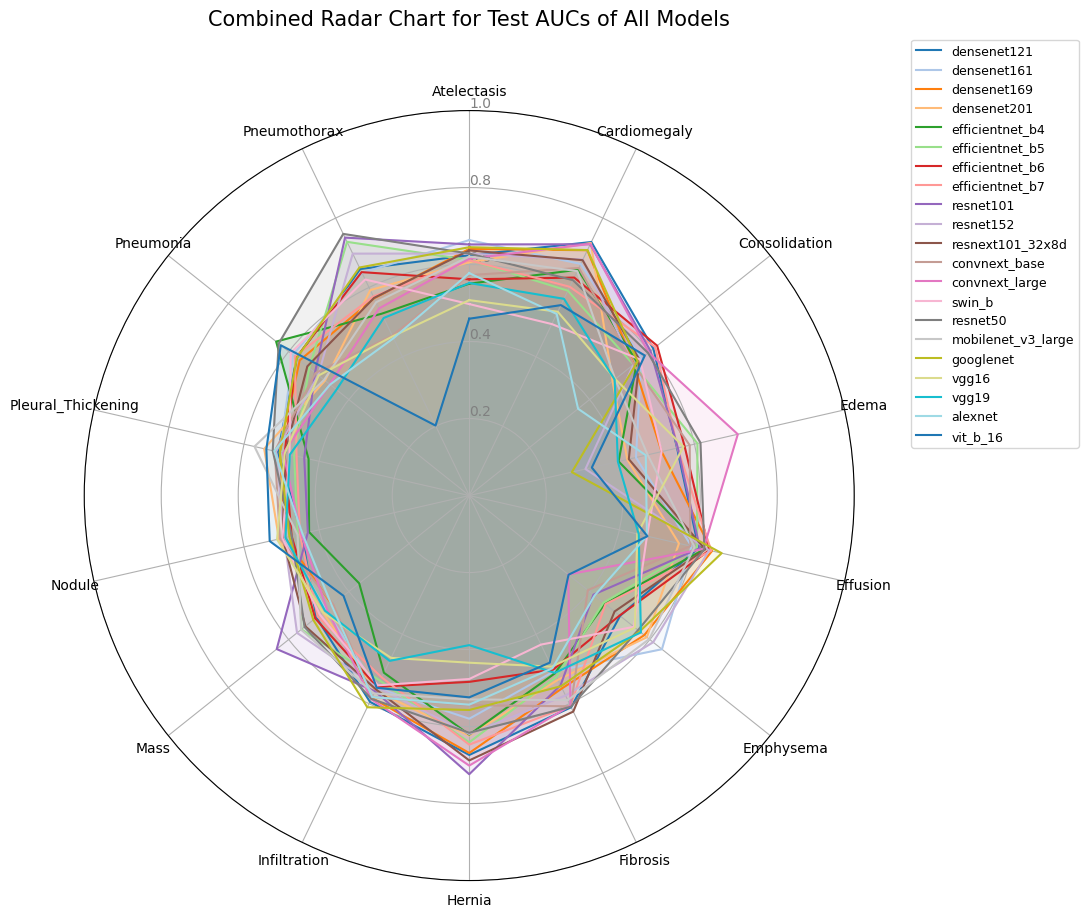

In [ ]:
results_df = pd.read_csv("detailed_model_results.csv")

plot_combined_radar_chart(results_df)

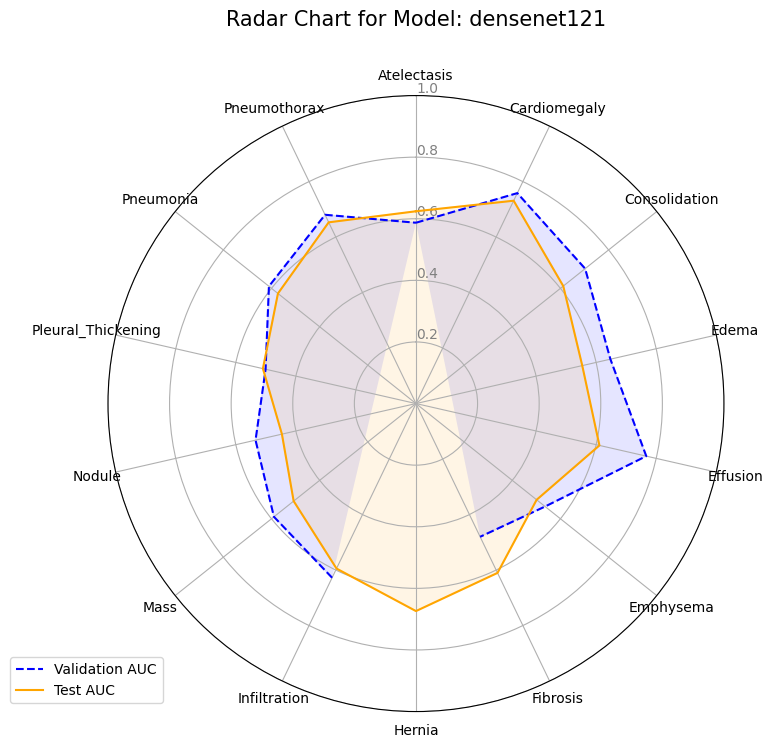

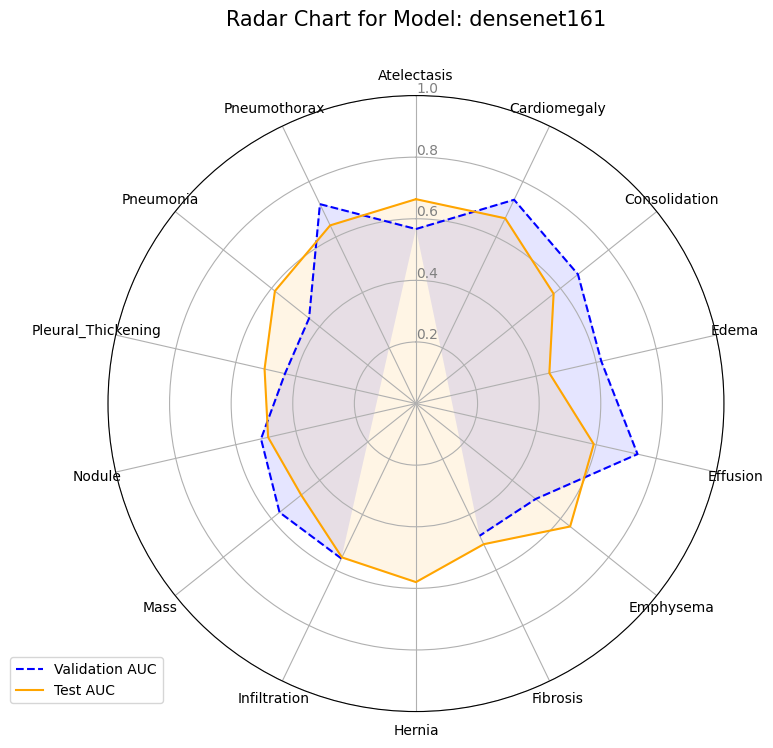

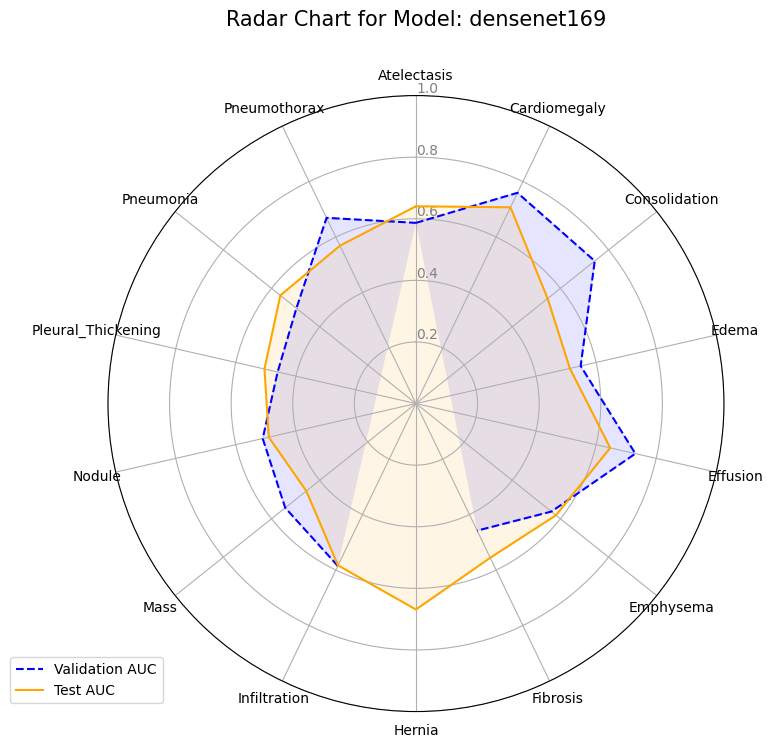

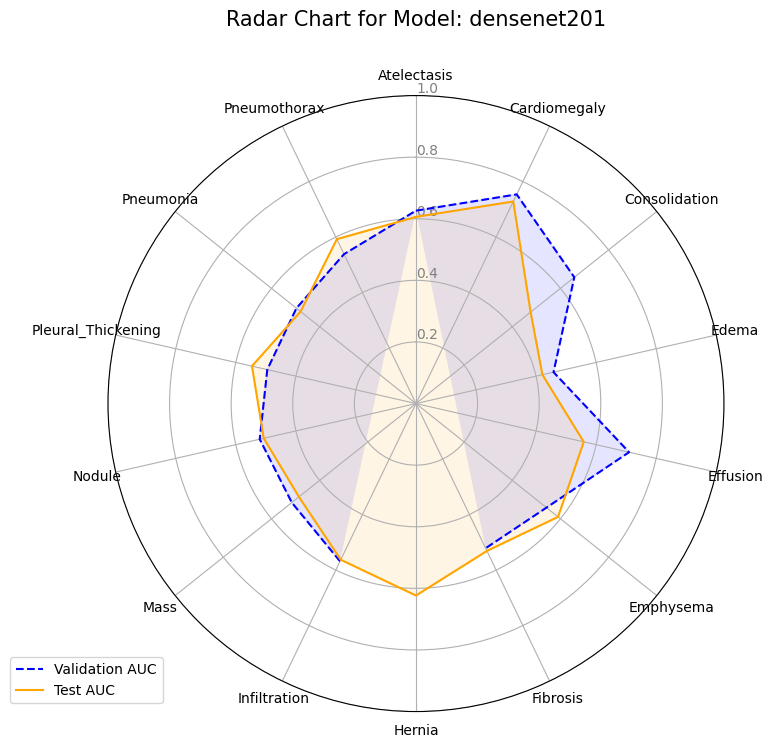

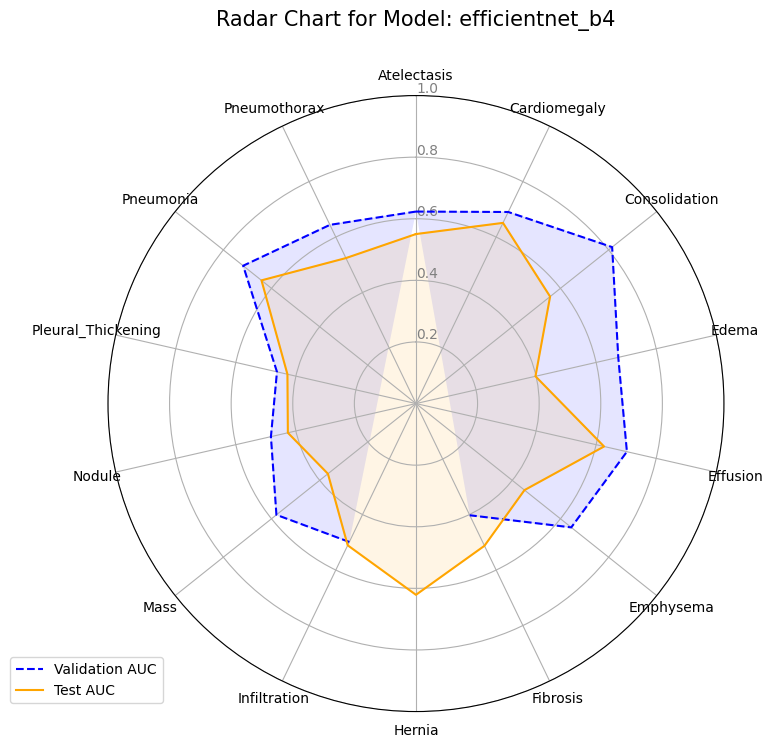

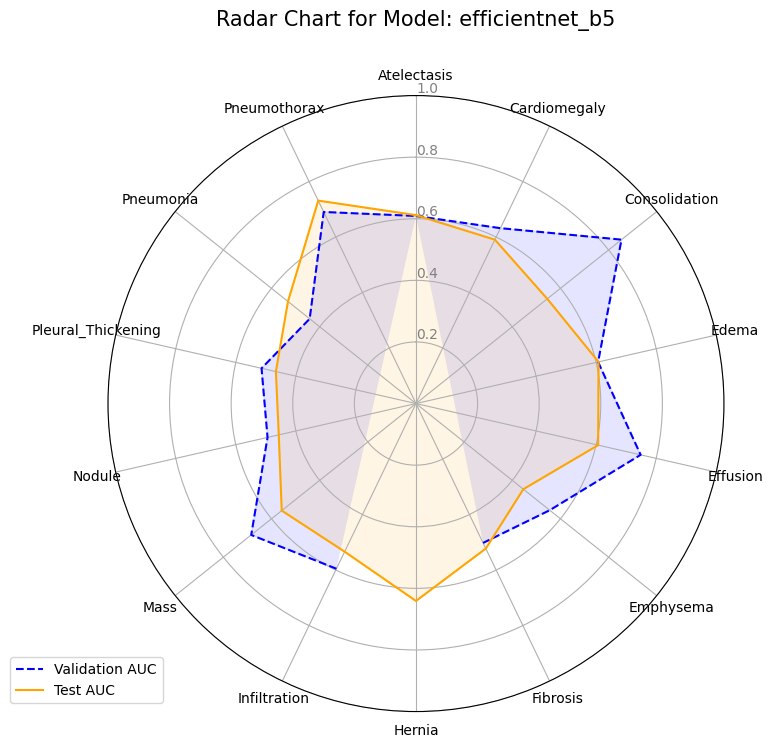

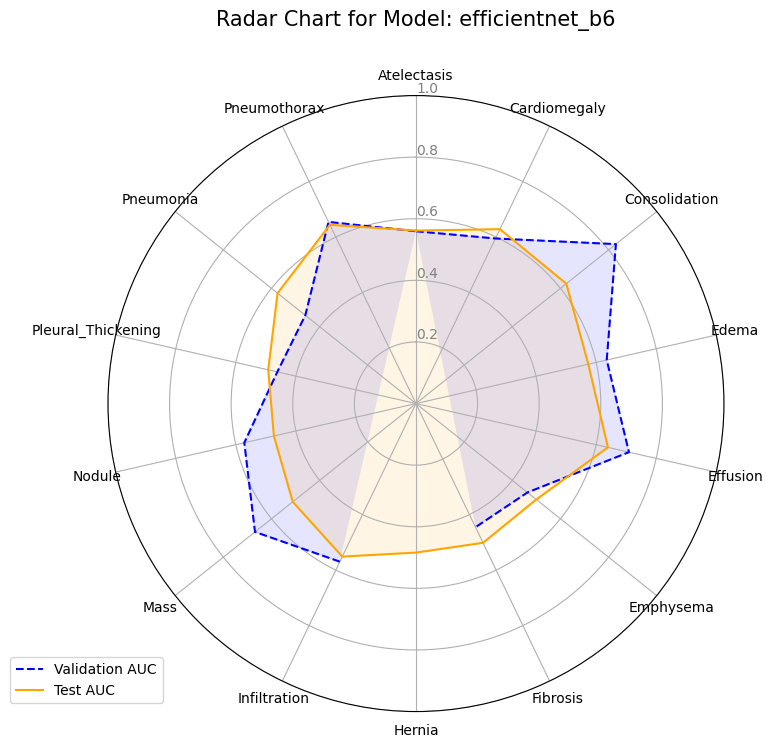

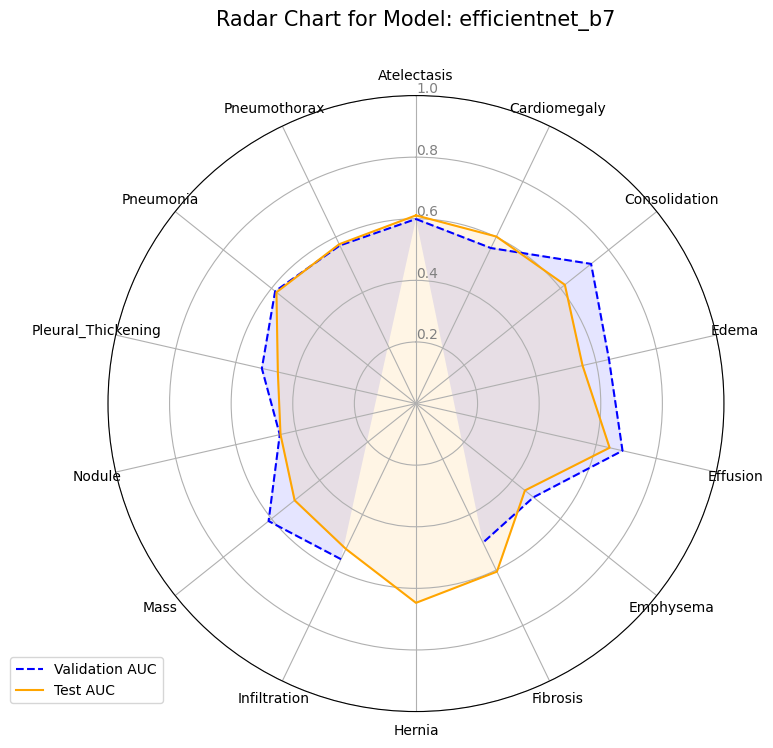

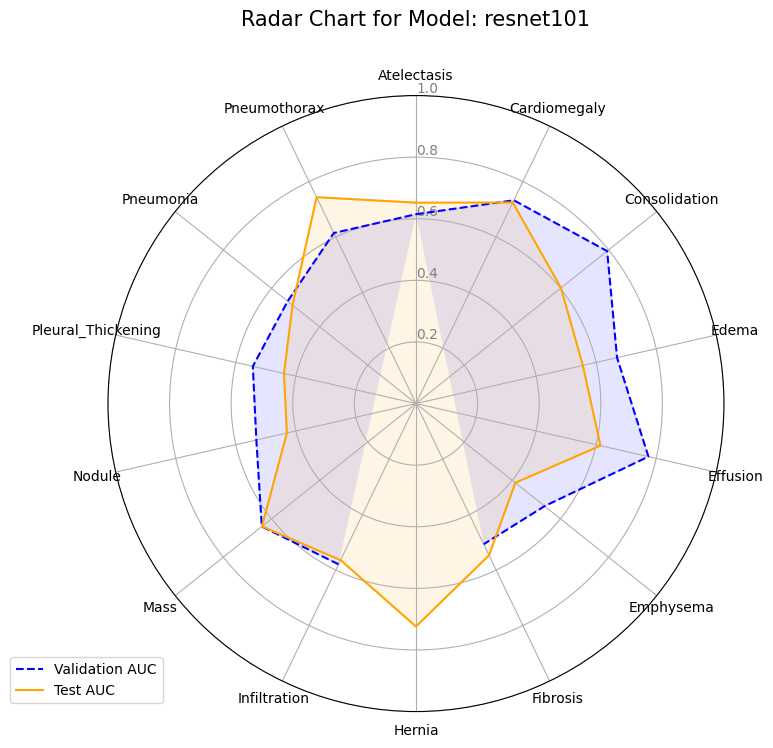

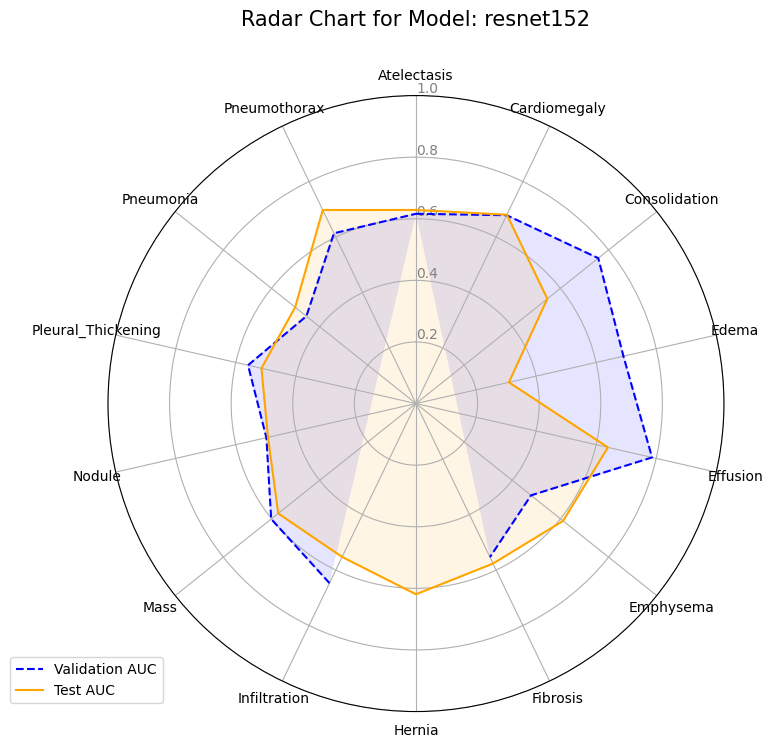

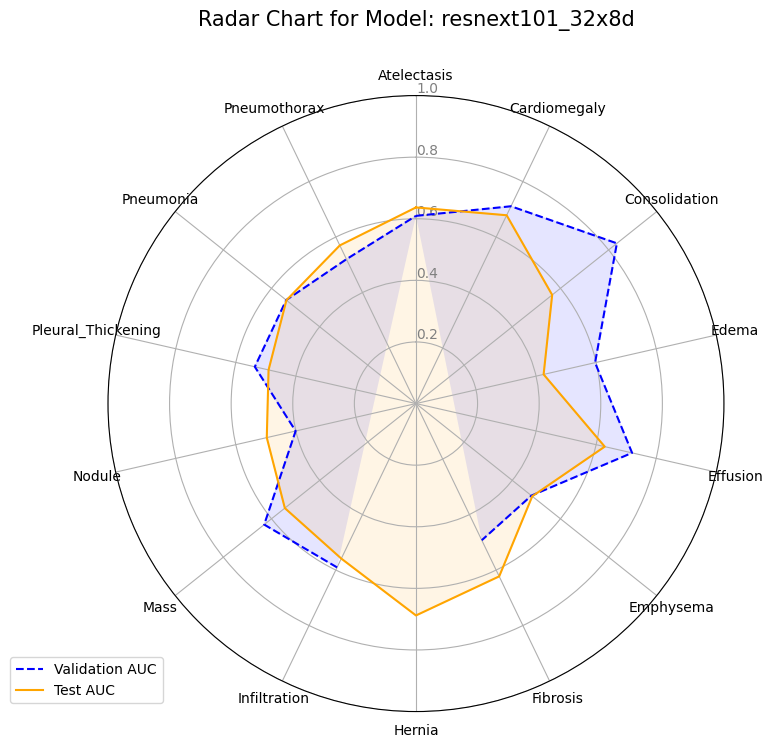

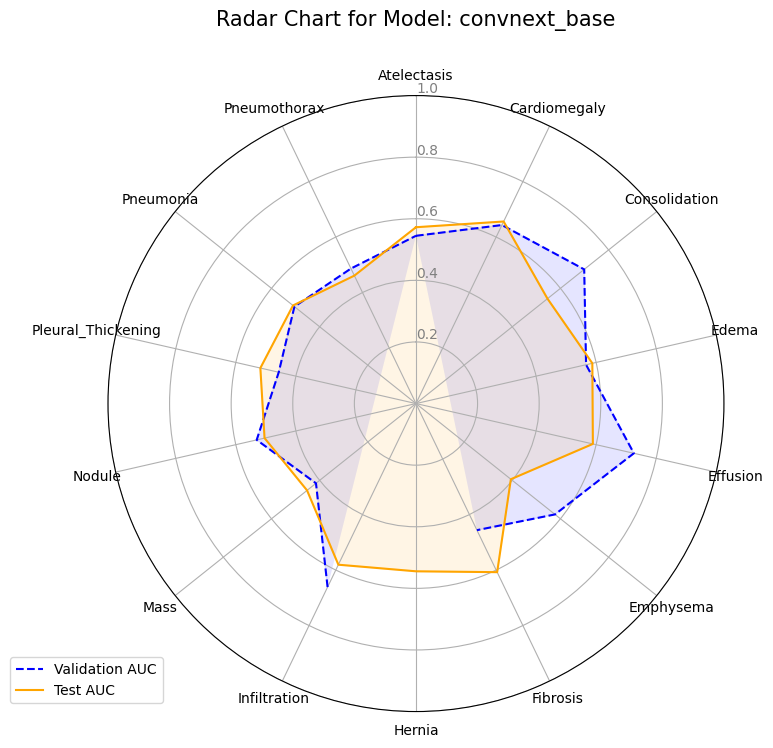

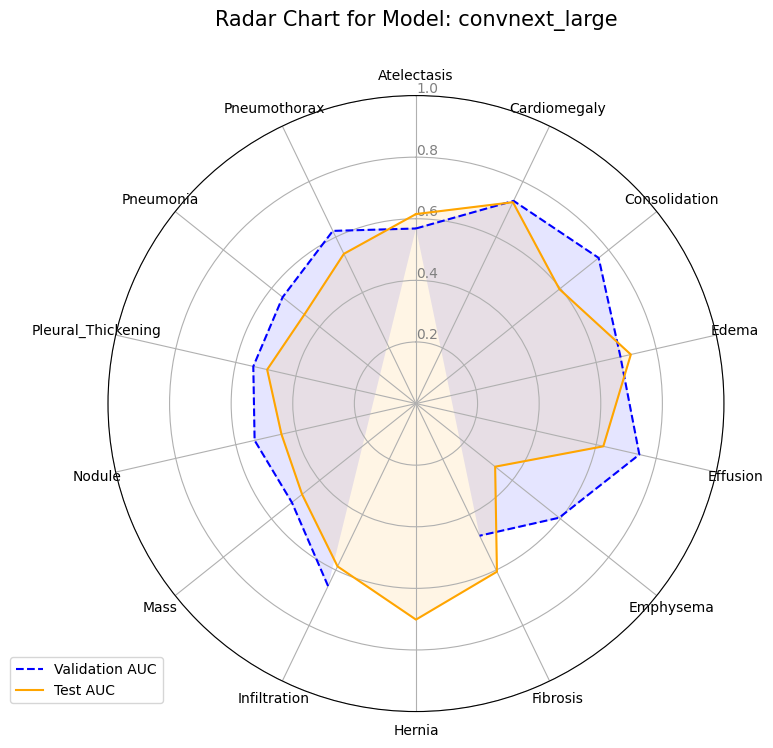

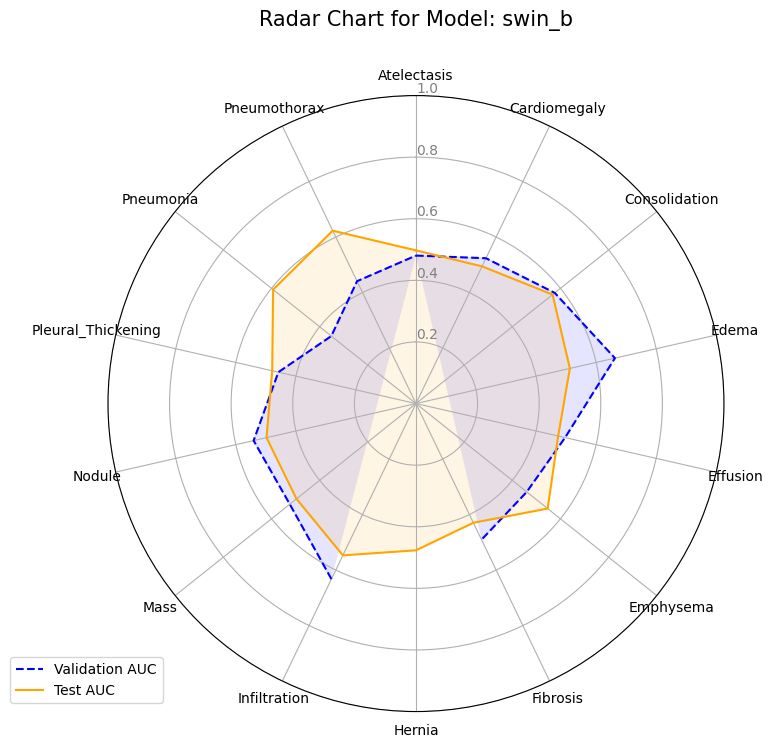

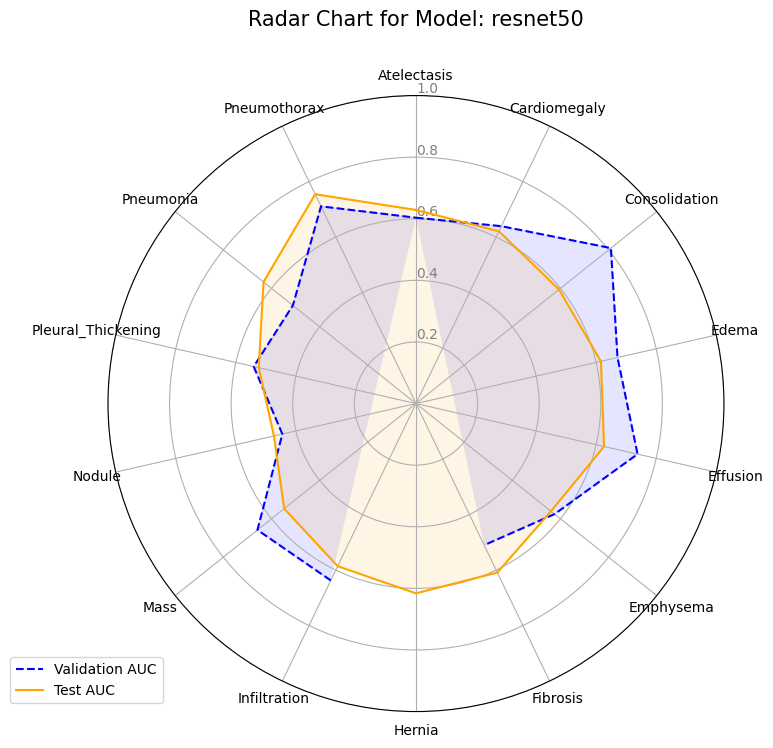

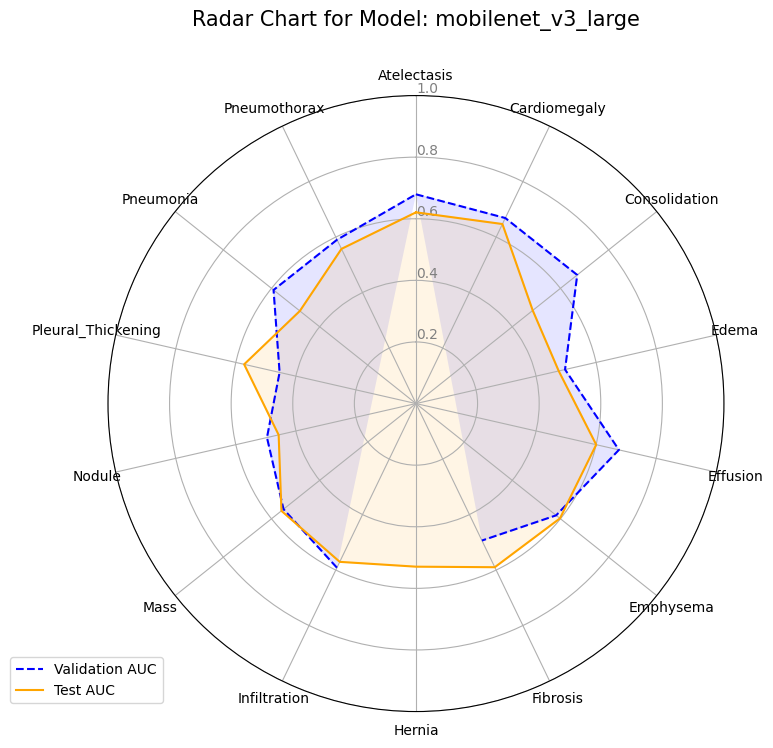

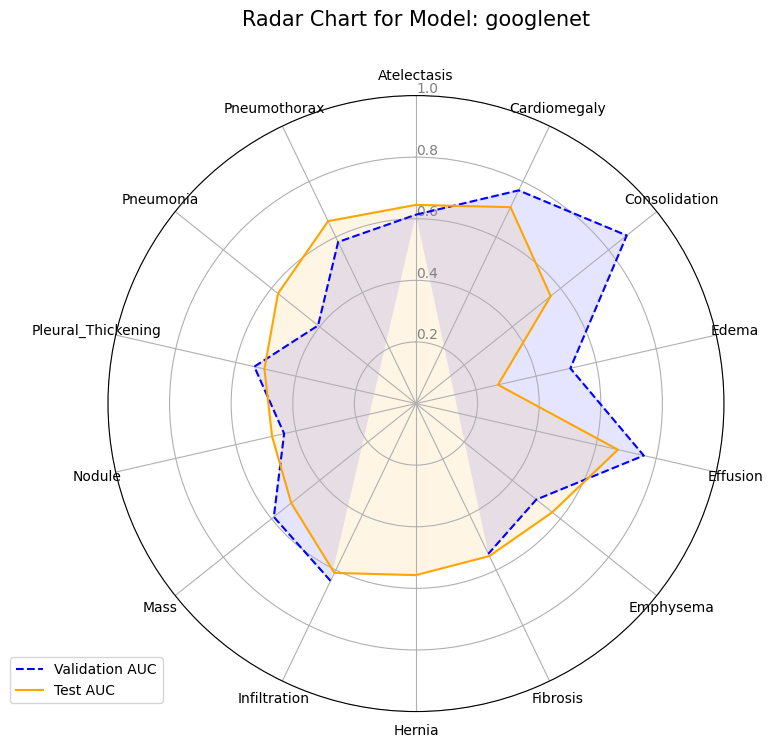

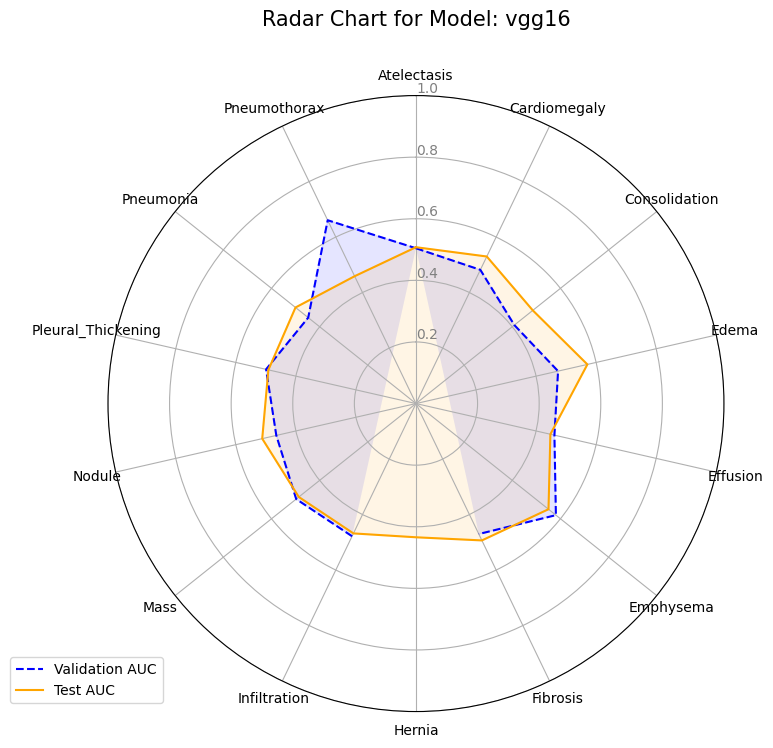

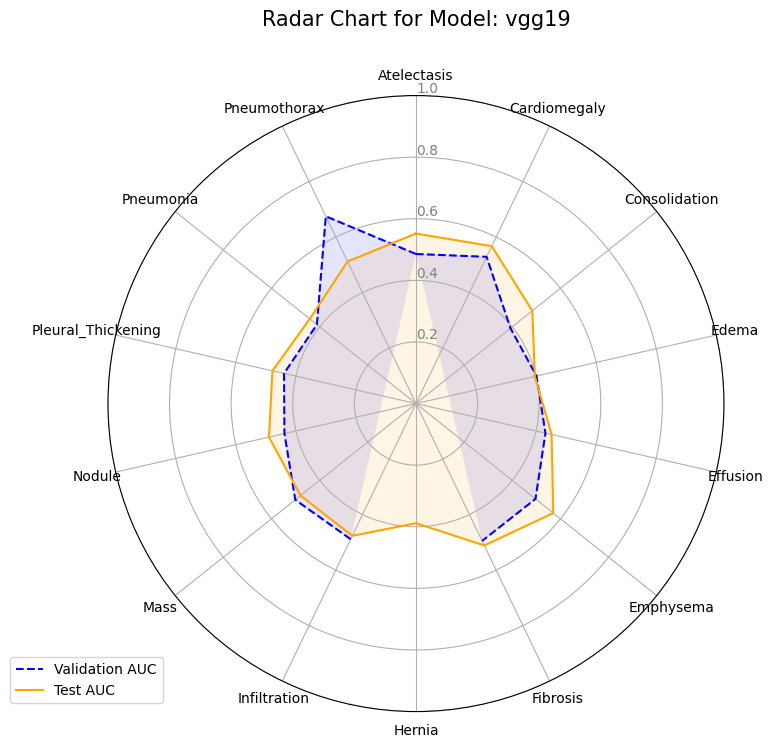

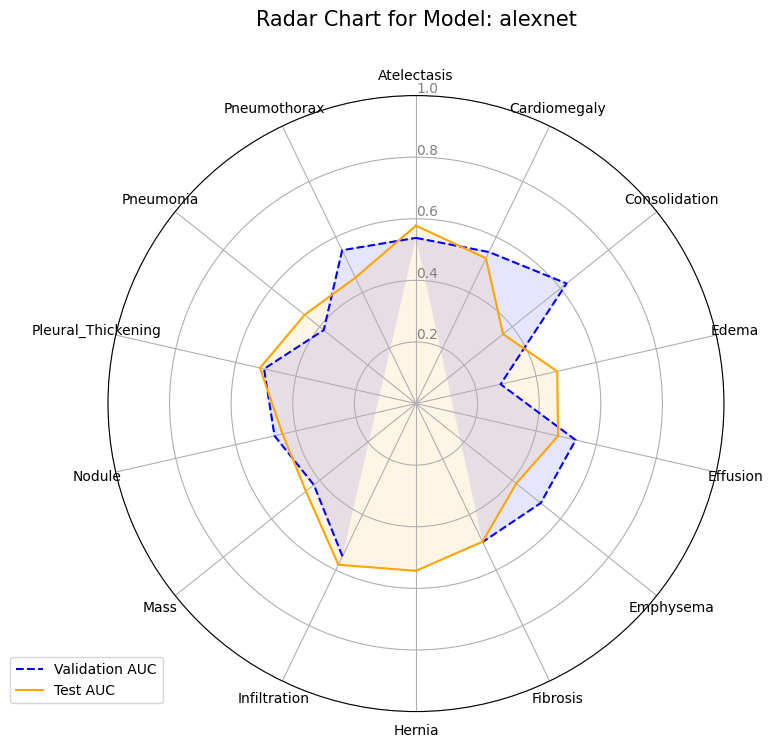

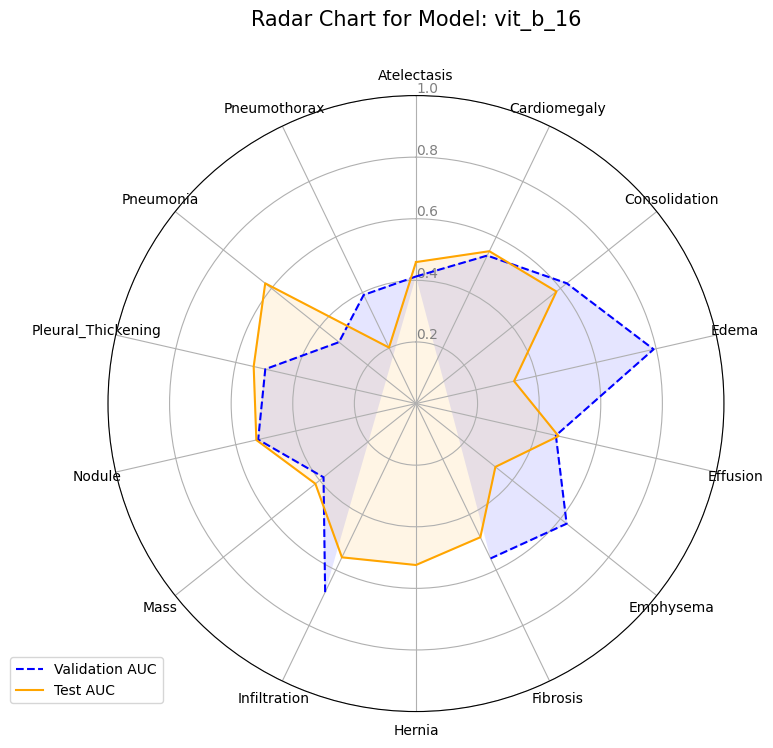

In [24]:
# Generate radar chart for each model
for model_name in results_df["Model"].unique():
    plot_radar_chart(model_name, results_df)